<center><h1><b>PROJECT</b></h1></center>

In [1]:
library(ggplot2)
library(dplyr)
library(stats)
library(sf)
library(geosphere)
library(patchwork)
library(reshape2)



Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE



---

## GUTHENBERG-RICHTER LAW 
(see wikipedia for more)  
In seismology, the Gutenberg–Richter law[1] (GR law) expresses the relationship between the magnitude and total number of earthquakes in any given region and time period of at least that magnitude.
$$ log_{10} ⁡ N = a − b \cdot M $$

where N is the number of events having a magnitude ≥ M, a and b are constants, i.e. they are the same for all values of N and M.
This relationship between event magnitude and frequency of occurrence is remarkably common, although the values of a and b may vary significantly from region to region or over time.   
Some generalization of this formula have been made.

#### PARAMETER b
The parameter b (commonly referred to as the "b-value") is commonly close to 1.0 in seismically active regions. This means that for a given frequency of magnitude 4.0 or larger events there will be 10 times as many magnitude 3.0 or larger quakes and 100 times as many magnitude 2.0 or larger quakes. There is some variation of b-values in the approximate range of 0.5 to 2 depending on the source environment of the region.[5] A notable example of this is during earthquake swarms when b can become as high as 2.5, thus indicating a very high proportion of small earthquakes to large ones. An earthquake swarm is a sequence of seismic events occurring in a local area within a relatively short period. The time span used to define a swarm varies, but may be days, months, or years. Such an energy release is different from the situation when a major earthquake (main shock) is followed by a series of aftershocks: in earthquake swarms, no single earthquake in the sequence is obviously the main shock. In particular, a cluster of aftershocks occurring after a mainshock is not a swarm. The b-value decrease observed prior to the failure of samples deformed in the laboratory[10] has led to the suggestion that this is a precursor to major macro-failure. Alternatively, a b-value significantly different from 1.0 may suggest a problem with the data set; e.g. it is incomplete or contains errors in calculating magnitude. 

#### PARAMETER a
The a-value represents the total seismicity rate of the region. This is more easily seen when the GR law is expressed in terms of the total number of events: 
$$ N = N_{TOT} \cdot 10^{-bM} $$ 
with $N_{TOT} = 10^{a}$ the total number of events (above M=0). Since $10^{a}$ is the total number of events, $10^{-bM}$ must be the probability of those events. 

#### OTHER MODELS
The basic model is the Gutenberg Richter
(GR) model that states the frequency’s logarithm is linearly
dependent on the magnitude. However, Dargahi-Noubary
(1986) and Kagan (1993) suggest that more suitable sta-
tistical models should be used instead of the GR model for
the distribution with high magnitudes. Petersen et al. (2007)
proposed a time-independent model showing that the prob-
ability of earthquake occurrence follows the Poisson dis-
tribution. Considering the time of earthquakes, stochastic
processes, especially Poisson processes, have also been used
to predict the number of earthquakes. However, the Poisson
model cannot be sufficient since it has an exponential recur-
rence time distribution and a constant hazard function. This
assumes that the probability of observing an earthquake at
any given time is independent of both elapsed time since
the last earthquake and its severity. This assumption leads
only to time-independent seismic hazard estimates. Besides,
earthquakes are clustered in time and space and their distri-
bution is over-dispersed compared to the Poisson law. [5]

In recent times, taking into account the seasonality and
trends of earthquakes, the prediction of the size or mag-
nitude has been performed in a few studies by time series
models such as Auto-Regressive Integrated Moving Aver-
age (ARIMA) and generalized autoregressive conditional
heteroskedasticity (GARCH).

a NEW BETTER MODEL IS The SSA is a nonparametric
novel and powerful time series analysis technique incorpo-
rating classical time series analysis, multivariate statistics,
multivariate geometry, dynamical systems, and signal pro-
cessing. This new method can be useful for the prediction of
the earthquake magnitude in a seismic region.

#### ARIMA MODEL
ARIMA, also known as Box-Jenkins models, is divided into
seasonal and non-seasonal models. Non-seasonal Box-Jenkins
models are generally shown as ARIMA (p, d, q), where
p is the parameter of the autoregression (AR) model, d is
the number of difference procedure, and q is the parameter
of the moving average (MA) model. To perform the analysis processes of the Box-Jenkins
method, first, care should be taken to ensure that the series
is free of trend and seasonal fluctuations, that is, the series
should be stationary. Then, determine the p and q param-
eters depending on the autocorrelation function and the par-
tial autocorrelation function graphs and control the model 
parameters’ significance. Lastly, the root mean square error
criterion (RMSE) is used to selects the best model among
the models having the white noise error series

---

## LOADING AND CLEANING DATA DATA
We took the data from https://earthquake.usgs.gov/ in two parts because there was a limit in the download size.

In [2]:
df1 = read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 = read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df = rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")

The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


Meaning of the less obvious comlumns:
* depth: Depth of the earthquake in kilometers (km).
* mag: Magnitude of the earthquake
* magType: Type of magnitude used. (maybe we should confront only earthquake with same magtype?)
* nst: Number of seismic stations that reported the event.
* gap: Largest azimuthal gap in station coverage (degrees).
* dmin: Distance to the nearest station (in degrees).
* rms: Root mean square of the travel time residuals (in seconds).
* net: Network that detected the event (e.g., us, ci, hv). It identifies the organization or seismic network responsible.
* id: The unique identifier for the earthquake event. It’s usually a string combining the net code and a unique event code.
* updated: Time the event information was last updated.
* place: Human-readable location (e.g., "10km SE of Town X").
* type: Type of seismic event (earthquake, quarry blast, etc.). But I only downloaded earthquakes so this column should be useless.
* horizontalError: Horizontal location error (in km or m).
* depthError: Error estimate for the depth (in km).
* magError: Error estimate for the magnitude.
* magNst: Number of stations used for magnitude calculation.
* status: Review status of the event (reviewed, automatic). It means whether the data has been automatically generated or manually reviewed by a seismologist.
* locationSource: Agency that determined the location.
* magSource: Agency that determined the magnitude.

Convert the time column to Date format:

In [3]:
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [4]:
summary(df)

      time                            latitude       longitude    
 Min.   :1925-02-07 12:14:58.150   Min.   :35.61   Min.   : 4.66  
 1st Qu.:1990-07-11 12:17:33.473   1st Qu.:39.37   1st Qu.:10.98  
 Median :1999-06-07 03:23:02.495   Median :42.74   Median :15.27  
 Mean   :1997-09-22 00:29:15.603   Mean   :42.17   Mean   :14.92  
 3rd Qu.:2004-10-01 01:05:55.349   3rd Qu.:44.44   3rd Qu.:20.01  
 Max.   :2025-06-24 03:04:54.730   Max.   :47.76   Max.   :20.87  
                                                                  
     depth             mag          magType               nst        
 Min.   : -2.00   Min.   :2.500   Length:28838       Min.   :  0.00  
 1st Qu.:  8.60   1st Qu.:2.700   Class :character   1st Qu.:  7.00  
 Median : 10.00   Median :3.100   Mode  :character   Median : 14.00  
 Mean   : 15.02   Mean   :3.284                      Mean   : 30.35  
 3rd Qu.: 10.00   3rd Qu.:3.600                      3rd Qu.: 35.00  
 Max.   :522.00   Max.   :7.000             

In [5]:
head(df,10)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,⋯,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,41,56,0.233,0.98,⋯,2025-06-24T08:13:22.962Z,"7 km N of Shijak, Albania",earthquake,4.47,1.932,0.110,23,reviewed,us,us
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,20,124,1.591,0.98,⋯,2025-06-21T15:51:45.040Z,"27 km SW of Lixoúri, Greece",earthquake,2.82,12.614,0.200,9,reviewed,us,us
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,41,107,1.563,1.14,⋯,2025-06-22T11:05:17.735Z,"38 km SW of Lixoúri, Greece",earthquake,6.06,1.895,0.079,47,reviewed,us,us
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,49,31,1.215,0.68,⋯,2025-06-22T16:37:44.040Z,"8 km ENE of Crnići, Bosnia and Herzegovina",earthquake,5.05,1.931,0.150,12,reviewed,us,us
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,33,42,0.670,0.82,⋯,2025-06-08T22:23:48.661Z,"12 km WNW of Igalo, Montenegro",earthquake,2.14,1.927,0.123,18,reviewed,us,us
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,25,79,0.369,0.60,⋯,2025-05-21T13:40:42.272Z,"2 km NE of Besenello, Italy",earthquake,2.28,5.934,0.057,40,reviewed,us,us
7,2025-05-13 10:07:45,40.8277,14.0646,10.000,4.0,mwr,65,105,0.432,0.45,⋯,2025-06-05T13:58:19.046Z,"3 km SW of Pozzuoli, Italy",earthquake,5.26,1.909,0.093,11,reviewed,us,us
8,2025-05-11 11:46:53,42.9684,18.6709,10.000,4.4,mb,47,37,0.692,0.79,⋯,2025-06-13T05:29:08.040Z,"22 km ENE of Bileća, Bosnia and Herzegovina",earthquake,4.11,1.932,0.130,17,reviewed,us,us
9,2025-05-10 04:51:34,38.0915,20.3410,42.571,4.1,mb,36,119,1.553,0.99,⋯,2025-05-26T22:31:13.040Z,"14 km SW of Lixoúri, Greece",earthquake,6.39,10.659,0.140,14,reviewed,us,us


### CLEANING

Not a very good dataset, there are many NA values. In particular many columns are almost useless for this (magError, depthError...).

Let's keep only useful columns:

In [6]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place', 'locationSource', 'status') ]

In [7]:
# check for NA values in selected columns:
for (col in 1:length(df_cleaned) ) {
    cat("Number of NA values in column ", col, ": ", sum(is.na(df_cleaned[1])), "\n")
}

Number of NA values in column  1 :  0 
Number of NA values in column  2 :  0 
Number of NA values in column  3 :  0 
Number of NA values in column  4 :  0 
Number of NA values in column  5 :  0 
Number of NA values in column  6 :  0 
Number of NA values in column  7 :  0 
Number of NA values in column  8 :  0 
Number of NA values in column  9 :  0 
Number of NA values in column  10 :  0 


In [8]:
df_cleaned <- df_cleaned %>% filter(grepl("Italy$", place))

head(df_cleaned)

,time,latitude,longitude,depth,mag,magType,id,place,locationSource,status
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,us7000q0g6,"2 km NE of Besenello, Italy",us,reviewed
2,2025-05-13 10:07:45,40.8277,14.0646,10.000,4.0,mwr,us7000pyym,"3 km SW of Pozzuoli, Italy",us,reviewed
3,2025-05-08 01:42:59,41.8207,12.7418,9.538,2.7,ml,us7000pxxr,"1 km NNE of Montecompatri, Italy",us,reviewed
4,2025-04-16 01:26:09,37.6250,16.1162,51.185,4.7,mb,us6000q6cn,"34 km SSE of Palizzi Marina, Italy",us,reviewed
5,2025-03-18 09:01:26,40.6596,15.8360,17.181,4.3,mwr,us6000pzjc,"3 km NE of Potenza, Italy",us,reviewed
6,2025-03-15 20:45:58,38.0732,12.2019,10.000,4.0,mb,us6000pz2t,"19 km NW of Favignana, Italy",us,reviewed


---

## Sismic map based on the Gutember-Richter law

In order to obtain a sismic map based on the Gutember'Richter law we will follow these steps:
- Divide the Region into Grid Cells
- Apply the Gutenberg-Richter Formula
  - Count the number of events above different magnitudes
  - Fit the G-R law using linear regression on $log_{10}(N)$ vs. $M$
  - Derive local $a$ and $b$ values
- Create heat maps:
  - One showing seismicity rate (the $a$ value)
  - One showing the relative hazard (via the b value—lower $b$ means more large earthquakes)


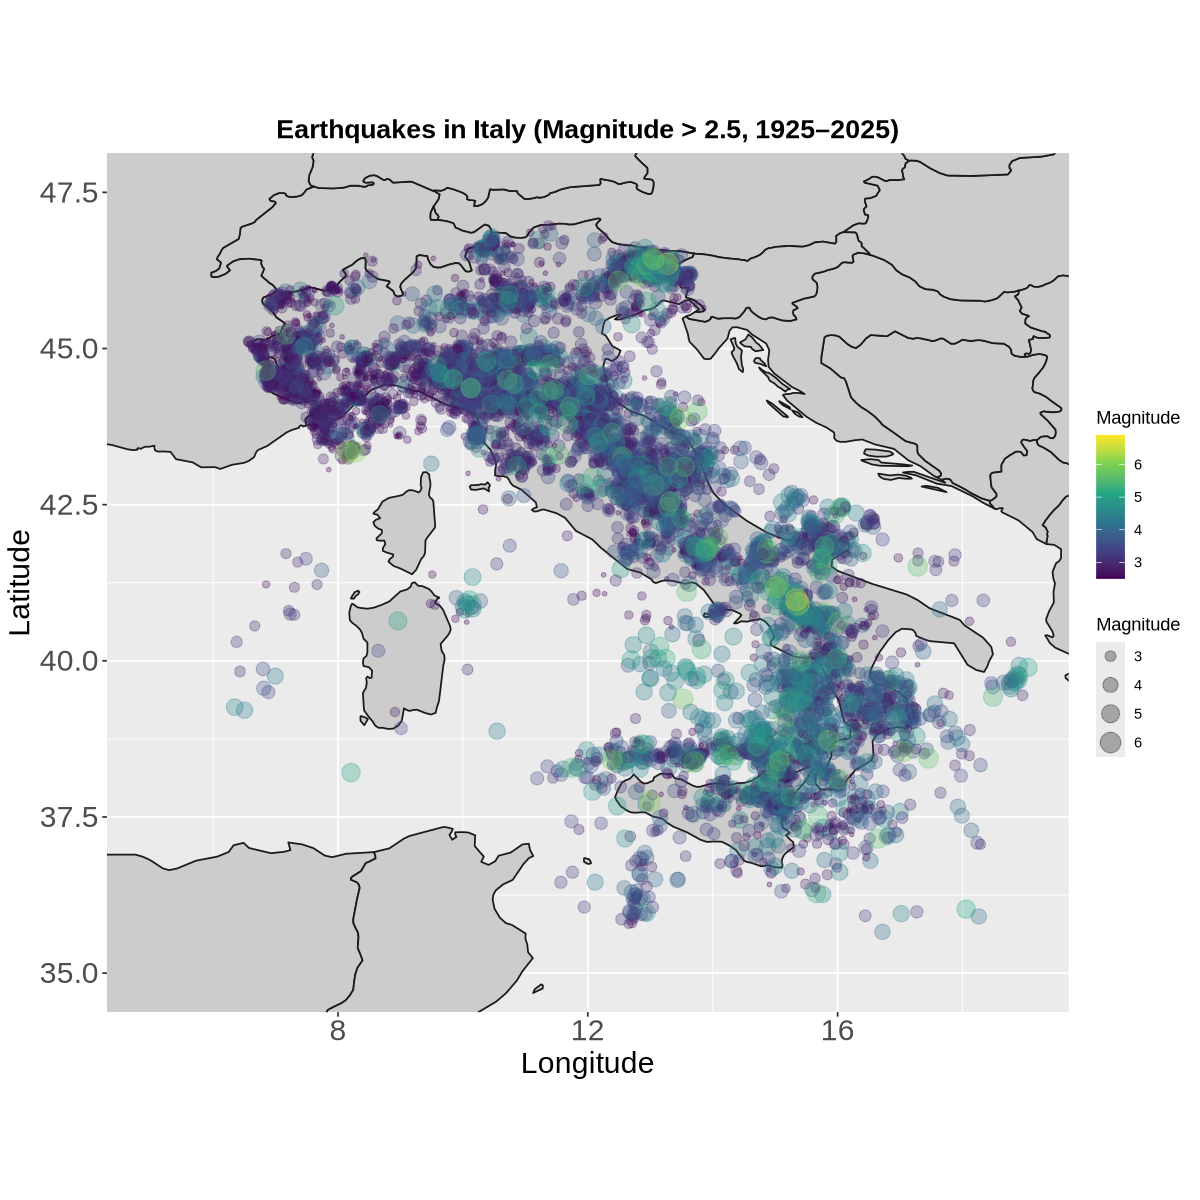

In [9]:
# Start simply visualizing the data

# image print out options
options(repr.plot.width=10, repr.plot.height=10)

# theme
proj_theme <- function() {
  theme(
    plot.title = element_text(
      face = "bold", # style: "plain", "italic", "bold"
      size = 16,
      color = "black",
      hjust = 0.5 # horizontal position (0 = left, 1 = right, 0.5 = center)
    ),
    axis.text.x = element_text(size = 18),
    axis.text.y = element_text(size = 18),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18)
  )
}

# regions to plot in the map
reg <- c("Italy", "Germany", "Switzerland", "France", "Austria", "Slovenia", "Croatia", 
        "Greece", "Albania", "Bosnia and Herzegovina", "Hungary", "Slovakia", "Liechtenstein", "Montenegro", 
        "Serbia", "Kosovo", "Romania", "North Macedonia", "Tunisia", "Algeria")

ggplot(df_cleaned, aes(x = longitude, y = latitude)) +
  # let's draw the map outline of Italy using the "maps" package
  borders("world", 
          regions = reg, fill = "gray80", colour = "gray10") +
  geom_point(aes(size = mag, color = mag), alpha = 0.3) +
  coord_fixed(xlim = c(5, 19), ylim = c(35, 47.5)) +    #  ensures the aspect ratio is preserved, so the map doesn’t look stretched
  scale_color_viridis_c() +
  labs(title = "Earthquakes in Italy (Magnitude > 2.5, 1925–2025)",
       x = "Longitude", 
       y = "Latitude", 
       color = "Magnitude", 
       size = "Magnitude") +
  proj_theme()

In [10]:
# set the values for the grid
lat_grid <- seq(min(df_cleaned$latitude), max(df_cleaned$latitude), 0.25)
lon_grid <- seq(min(df_cleaned$longitude), max(df_cleaned$longitude), 0.25)
mag_values <- seq(4,7,0.1)  # groups of magnitudes => levels of the array to hold the data

# N is a matrix that cointains the number of earthquakes cell by cell
j <- 1:(length(lat_grid)-1)
k <- 1:(length(lon_grid)-1)
i <- 1:(length(mag_values)-1)
N <- array(0, dim = c(length(j), length(k), length(i)))
        
for (lat_i in j){
    for (lon_i in k){
        for (mag_i in i){
        N[lat_i, lon_i, mag_i] <- nrow(df_cleaned[df_cleaned$latitude < lat_grid[lat_i+1] & 
                df_cleaned$latitude >= lat_grid[lat_i] & 
                df_cleaned$longitude < lon_grid[lon_i+1] & 
                df_cleaned$longitude >= lon_grid[lon_i] & 
                df_cleaned$mag >= mag_values[mag_i] , ])
        }
    }
}


In [11]:
# Check the array dimension
cat("The array dimension are: ", dim(N))

The array dimension are:  45 50 30

In [12]:
# perform the fit cell by cell

# create empty matrices
b_values <- matrix(NA, nrow = length(j), ncol = length(k))
a_values <- matrix(NA, nrow = length(j), ncol = length(k))

for (lat_i in j){
  for (lon_i in k){
    counts <- N[lat_i, lon_i, ]
    mags <- mag_values[-length(mag_values)]  # since N uses intervals
    if (sum(counts != 0) >= 7 ) {  # ensure enough data 
      log_N <- log10(counts)
      log_N[!is.finite(log_N)] <- NA  # convert -Inf to NA
      fit <- lm(log_N ~ mags)
      # save the fit coefficients
      b_values[lat_i, lon_i] <- -coef(fit)[2] 
      a_values[lat_i, lon_i] <- coef(fit)[1]
    }
  }
}

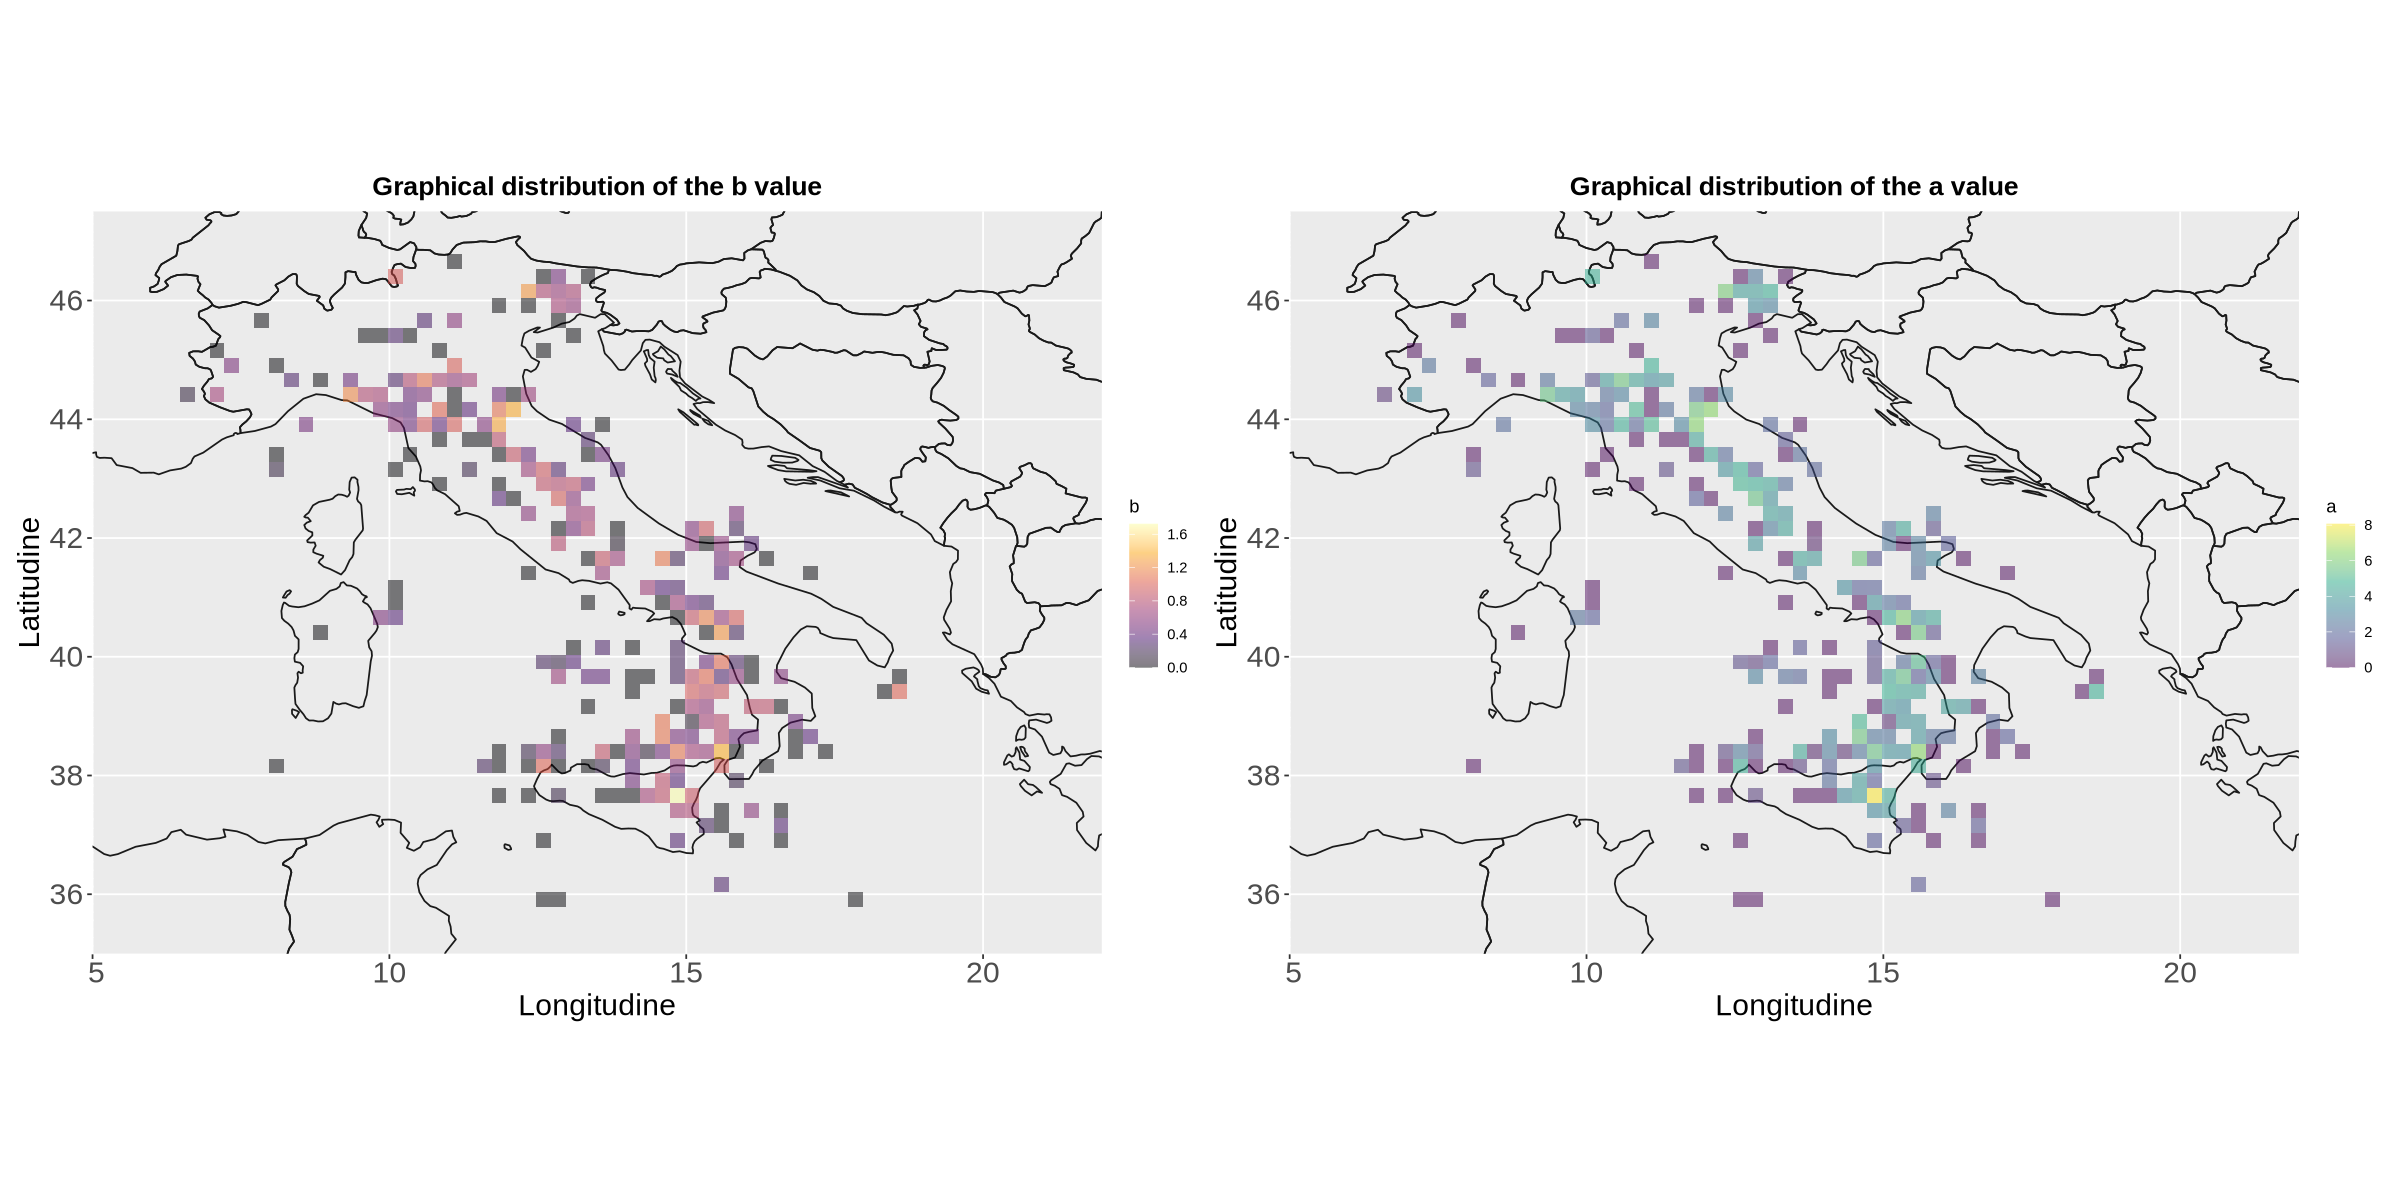

In [13]:

# prepare the data in a dataframe
b_df <- melt(b_values)
a_df <- melt(a_values)
colnames(b_df) <- c("lat_index", "lon_index", "b_value")
colnames(a_df) <- c("lat_index", "lon_index", "a_value")

b_df$lat <- lat_grid[b_df$lat_index]
b_df$lon <- lon_grid[b_df$lon_index]
a_df$lat <- lat_grid[a_df$lat_index]
a_df$lon <- lon_grid[a_df$lon_index]


# plot the a and b values in a grid 

b_plot <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  #geom_sf(data = placche, color = "blue", size = 2) +

  # heatmap for the b parameter
  geom_tile(data = b_df, aes(x = lon, y = lat, fill = b_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "inferno", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the b value", x = "Longitudine", y = "Latitudine", fill = "b") +
  proj_theme()

#----------------------------------------------------------------------------------------------------------

a_plot  <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  #geom_sf(data = placche, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = a_df, aes(x = lon, y = lat, fill = a_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "viridis", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the a value", x = "Longitudine", y = "Latitudine", fill = "a") +
  proj_theme()




options(repr.plot.width = 20, repr.plot.height = 10)
b_plot + a_plot

- **b-value map**: It highlights areas where seismicity is dominated by small earthquakes ($b > 1$) or by strong events ($b < 1$). High values are typical of swarms.
- **a-value map**: It shows the absolute level of seismic activity. Areas with high values have many earthquakes, regardless of magnitude.



In [15]:
#  https://www.usgs.gov/programs/earthquake-hazards/google-earthtmkml-files -> page where you can find the file for the edge of the plates
# Instructions: 1) Rename the file to .zip; 2) Extract the file; 3) Get the .kml file;
layers_info <- st_layers("doc.kml")
print(layers_info)

Driver: LIBKML 
Available layers:
                          layer_name geometry_type features fields crs_name
1                   Plate Boundaries                      0     13   WGS 84
2                    Plate Interface                   1175     13   WGS 84
3 Micro Plates and Major Fault Zones                    221     13   WGS 84
4                       Plate Motion                    191     12   WGS 84


In [16]:
plates<- st_read("doc.kml", layer = "Plate Interface")

Reading layer `Plate Interface' from data source 
  `/home/pira/Documenti/PoD/AdvancedStatistics/Earthquakes_Analysis_Italy/doc.kml' 
  using driver `LIBKML'
Simple feature collection with 1175 features and 13 fields
Geometry type: MULTILINESTRING
Dimension:     XYZ
Bounding box:  xmin: -180 ymin: -66.163 xmax: 180 ymax: 86.805
z_range:       zmin: 0 zmax: 0
Geodetic CRS:  WGS 84


Simple feature collection with 1175 features and 13 fields
Geometry type: MULTILINESTRING
Dimension:     XYZ
Bounding box:  xmin: -180 ymin: -66.163 xmax: 180 ymax: 86.805
z_range:       zmin: 0 zmax: 0
Geodetic CRS:  WGS 84
First 10 features:
         id                    Name
1  ID_00000 Eurasian:North American
2  ID_00001 Eurasian:North American
3  ID_00002 Eurasian:North American
4  ID_00003 Eurasian:North American
5  ID_00004 Eurasian:North American
6  ID_00005 Eurasian:North American
7  ID_00006 Eurasian:North American
8  ID_00007 Eurasian:North American
9  ID_00008 Eurasian:North American
10 ID_00009 Eurasian:North American
                                                                                                                                                                                                                                                                                                                                                                        

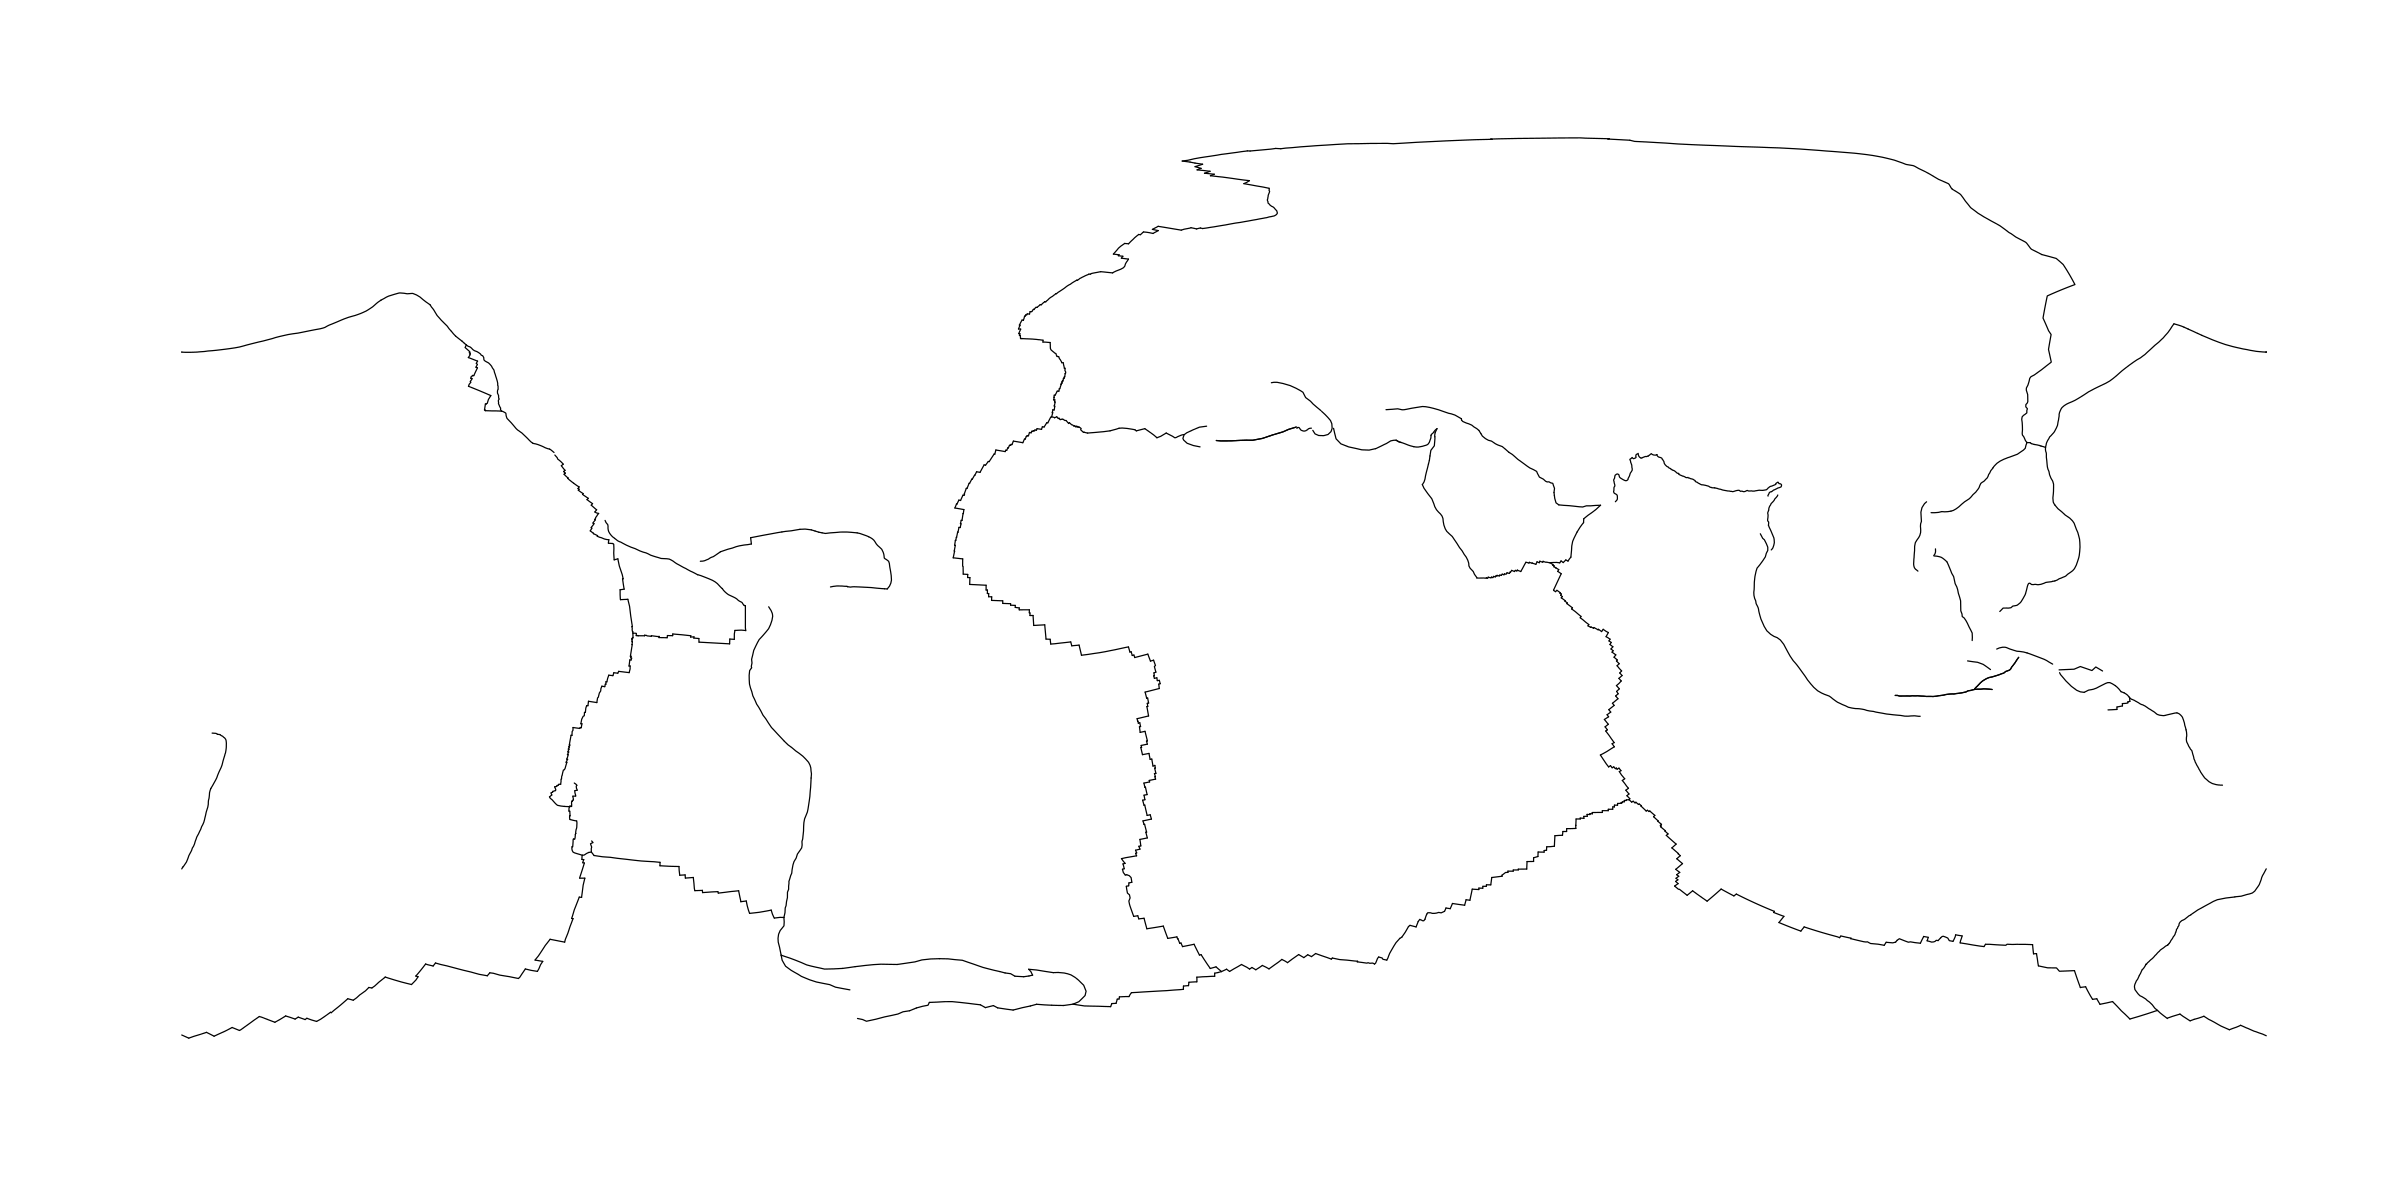

In [17]:
# Check that all is working well
print(plates)
plot(st_geometry(plates))  

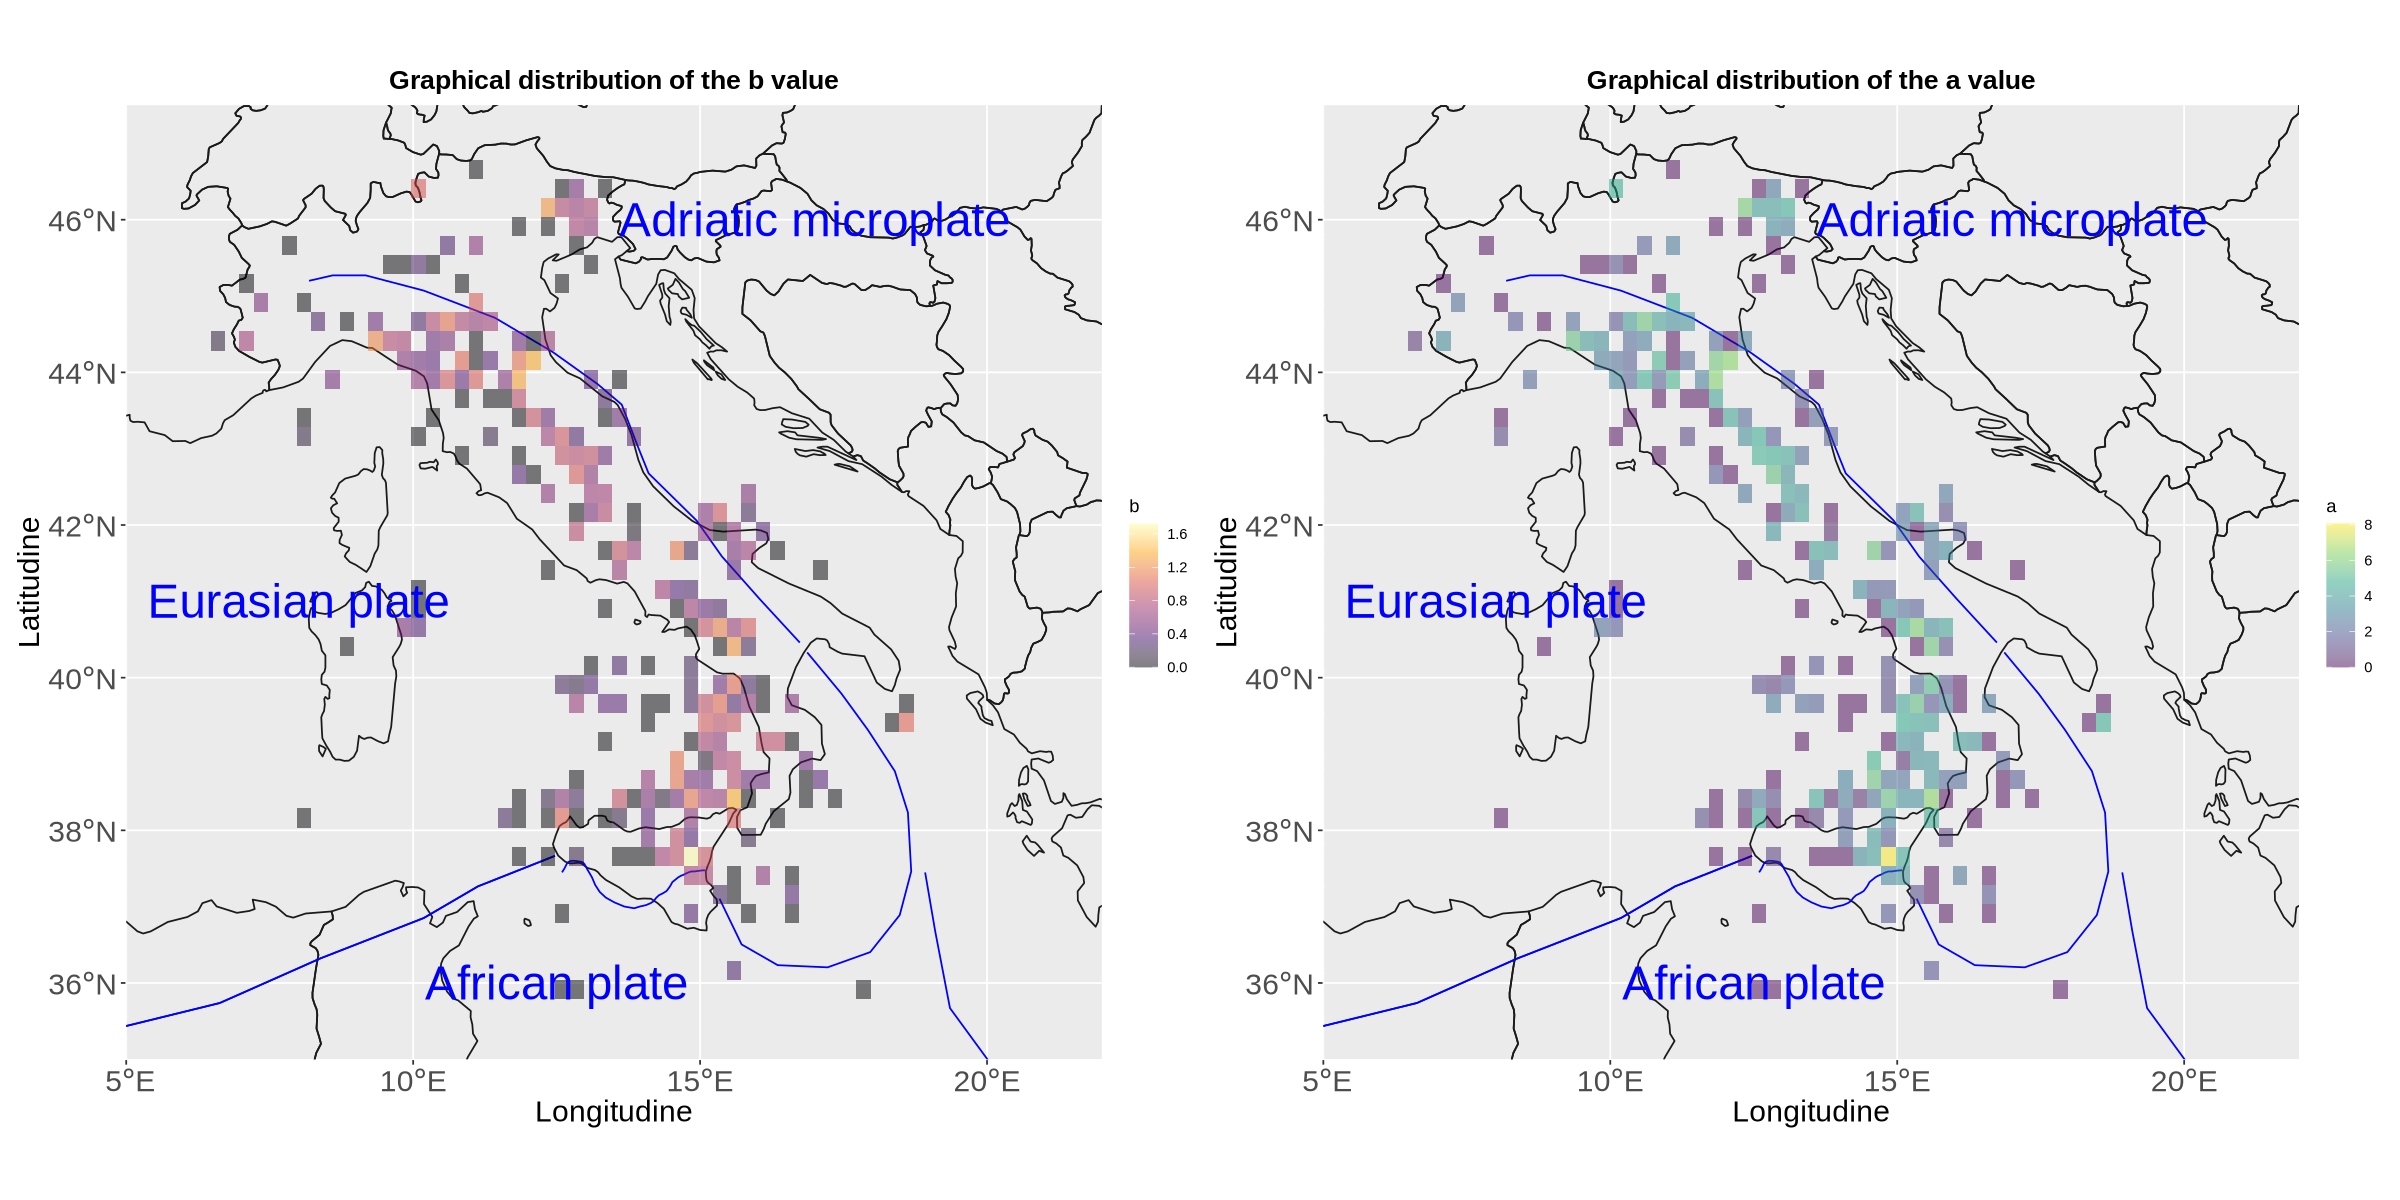

In [28]:
plates_names <- function() {
  annotate("text", x = c(8, 17, 12.5), y = c(41, 46, 36),
           label = c("Eurasian plate", "Adriatic microplate", "African plate"),
           size = 10, color = "blue")
}

# add add tectonic plate boundaries
a_plot_plates <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  geom_sf(data = plates, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = a_df, aes(x = lon, y = lat, fill = a_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "viridis", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the a value", x = "Longitudine", y = "Latitudine", fill = "a") +
  proj_theme()+
    plates_names()


b_plot_plates <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # placche tettoniche
  geom_sf(data = plates, color = "blue", size = 2) +

  # heatmap parametro b
  geom_tile(data = b_df, aes(x = lon, y = lat, fill = b_value), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "inferno", na.value = "transparent", alpha = 0.5) +
  labs(title = "Graphical distribution of the b value", x = "Longitudine", y = "Latitudine", fill = "b") +
  proj_theme()+
    plates_names()
b_plot_plates + a_plot_plates

We can now construct a naive model based on the G-R law parameters found in the previous step. We assume that high-magnitude earthquakes are rare events, that they occur at a constant average number, and that they are independent events. Therefore, they follow a Poisson distribution. I then calculate, area by area, the probability of having $n$ events of magnitude greater than or equal to a threshold value in the next $k$ years.



In [58]:
# Threshold
M_threshold <- 5
years <- 5
n <- 5

# Probabilities matrices
P_strong <- matrix(NA, nrow = length(j), ncol = length(k))

for (lat_i in j){
  for (lon_i in k){
    a <- a_values[lat_i, lon_i]
    b <- b_values[lat_i, lon_i]
    if (!is.na(a) & !is.na(b) ){
      lambda <- 10^(a - b * M_threshold) * years
      P_strong[lat_i, lon_i] <- 1 - dpois(n, lambda)
    }
  }
}

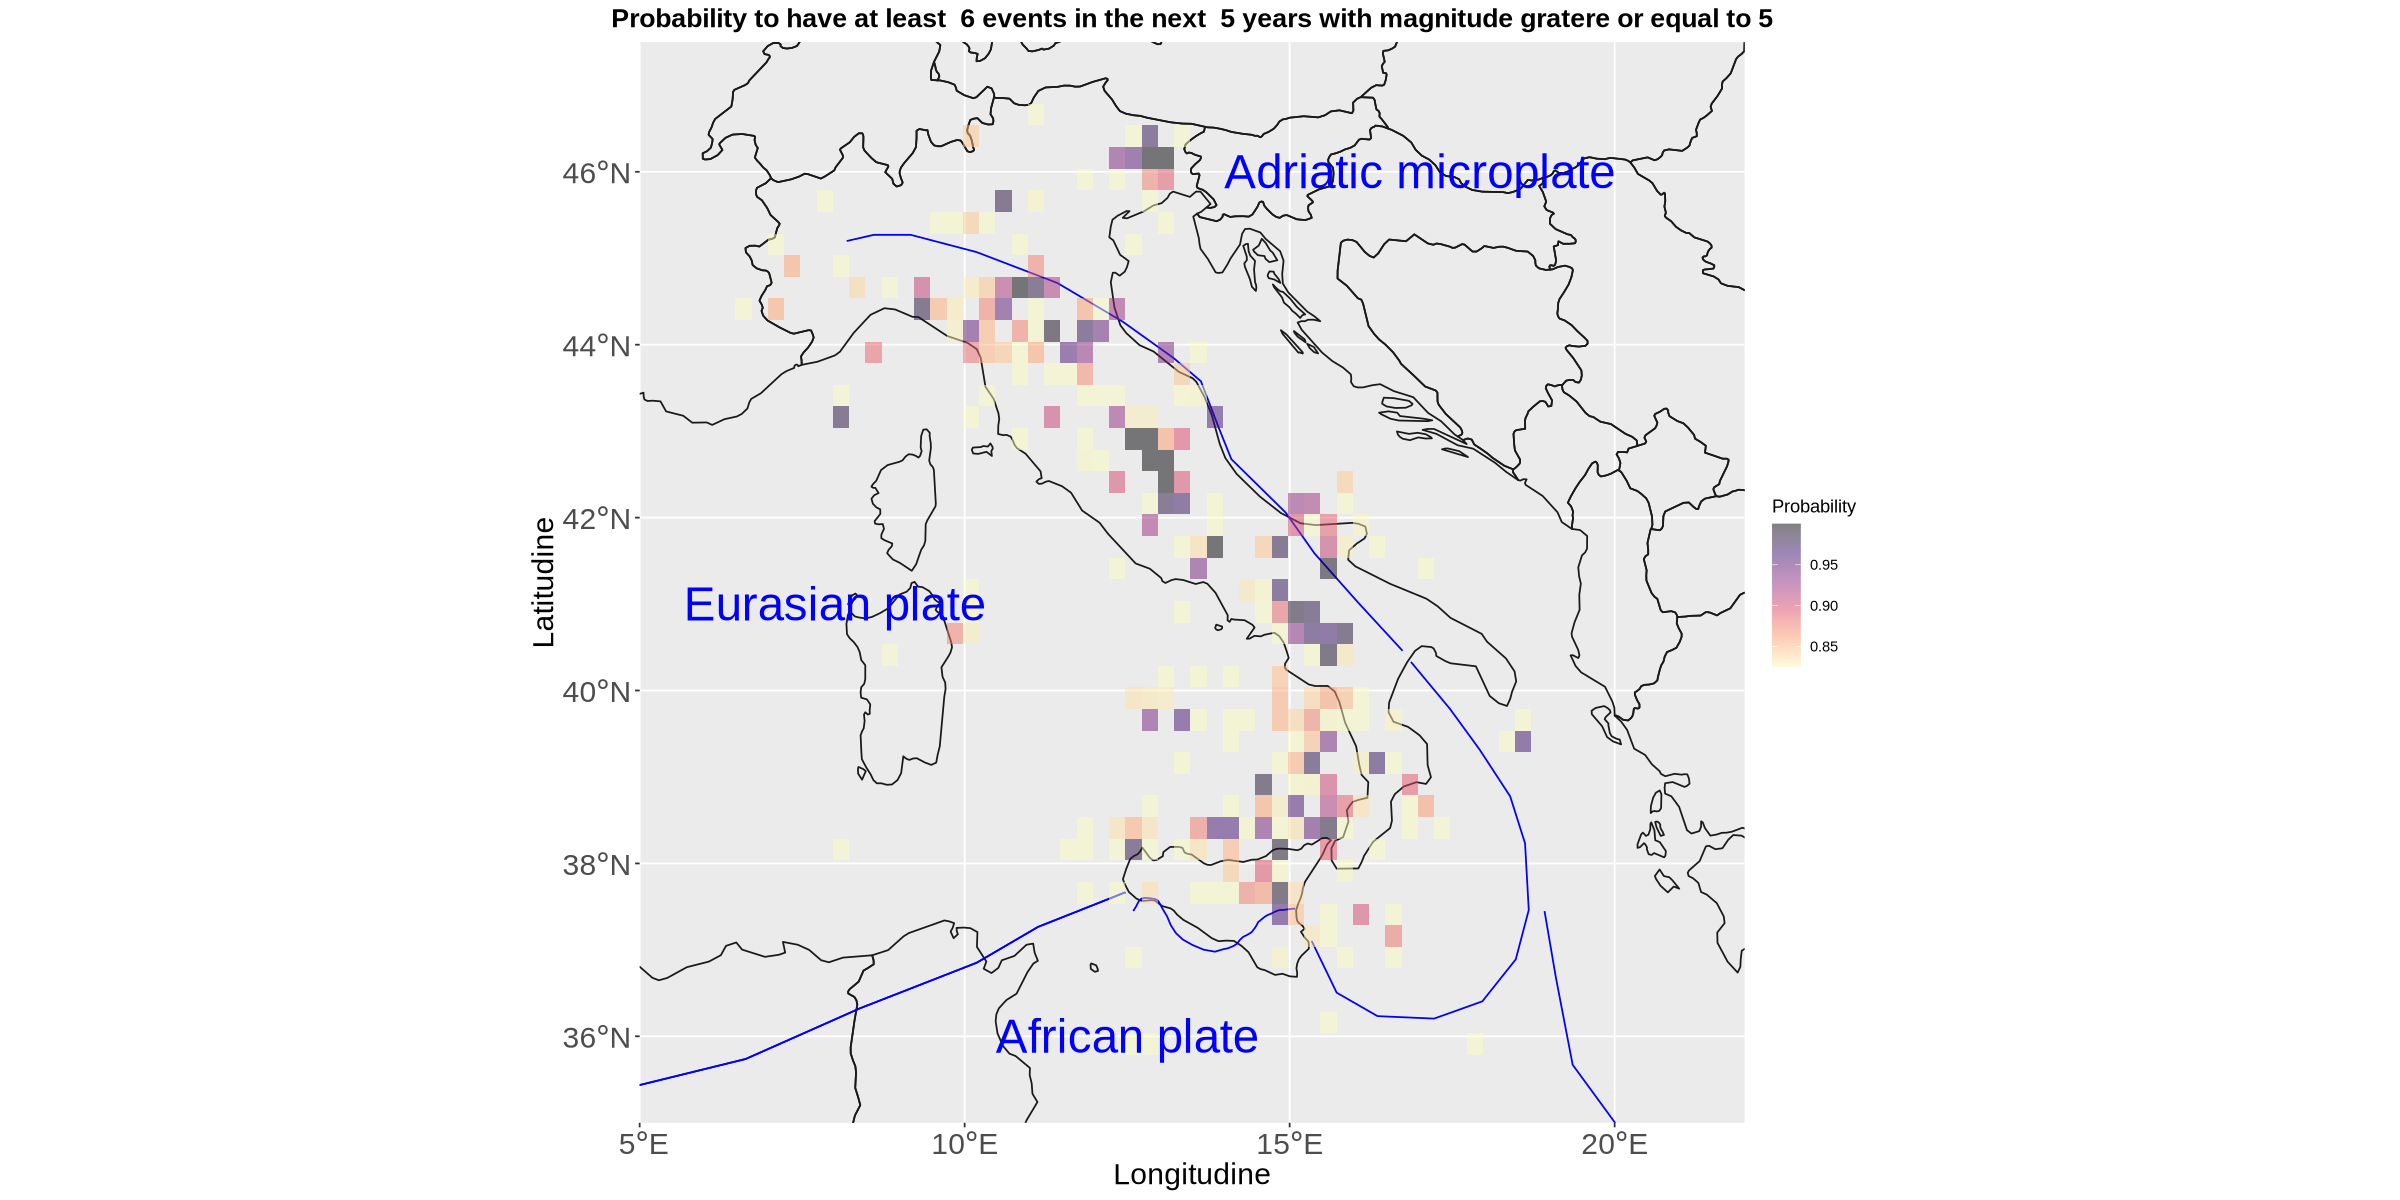

In [63]:
# Prepare the dataframe
P_df <- melt(P_strong)

colnames(P_df) <- c("lat_index", "lon_index", "prob")

P_df$lat <- lat_grid[P_df$lat_index]
P_df$lon <- lon_grid[P_df$lon_index]


prob_plot <- ggplot() +
  # borders
  borders("world", 
          regions = c(reg), 
          fill = "gray80", colour = "gray10", alpha = 0) +

  # tectonics plates
  geom_sf(data = plates, color = "blue", size = 2) +

  # probability heatmap 
  geom_tile(data = P_df, aes(x = lon, y = lat, fill = prob), color = NA, na.rm = TRUE) +
  coord_sf(xlim = c(5, 22), ylim = c(35, 47.5), expand = FALSE) +
  scale_fill_viridis_c(option = "magma", na.value = "transparent", alpha = 0.5, direction=-1) +
  labs(title = paste("Probability to have at least ", n+1, "events in the next ", years, "years", "with magnitude gratere or equal to", M_threshold ), x = "Longitudine", y = "Latitudine", fill = "Probability") +
  proj_theme()+
    plates_names()

prob_plot